In [101]:
import numpy as np
import pandas as pd
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import PreTrainedTokenizerFast, GPT2LMHeadModel, GPT2TokenizerFast, GPT2Tokenizer
from transformers import Trainer, TrainingArguments
import re
import os
import nltk
import random
import seaborn as sns
from typing import List
import torch
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import unicodedata

In [2]:
k = pd.read_csv('/kaggle/input/amazon-reviews-supplements/product_asin.csv')
k.head()

,X,title,parent_asin,categories,cat1,cat2,cat3,cat4,cat5,cat6
0,1,Allegra Allergy 45ct + 15 Free,B00JENH5OI,['Health & Household','Health Care','Over-the-Counter Medication','Allergy,Sinus & Asthma','Allergy Medicine'],NaN
1,2,InvoSpa Shiatsu Back Shoulder and Neck Massage...,B0C4L5Y711,['Health & Household','Wellness & Relaxation','Massage Tools & Equipment','Electric Massagers','Back Massagers'],NaN,NaN
2,4,"Kal 100 Mcg Selenium Yeast Free Tablets, 100 C...",B00020HX5S,['Health & Household','Vitamins,Minerals & Supplements','Vitamins','Multivitamins'],NaN,NaN
3,5,Rocky Mountain Oils Cinnamon Bark Essential Oi...,B07K363N3S,['Health & Household','Health Care','Alternative Medicine','Aromatherapy'],NaN,NaN,NaN
4,12,"Prevail Super Absorbent Underpads, Prevail Sup...",B00ACMDOOA,['Health & Household','Health Care','Incontinence & Ostomy','Protective Briefs & Underwear'],NaN,NaN,NaN


In [3]:
df = pd.read_csv('/kaggle/input/amazon-reviews-supplements/reviews_supplements.csv')
df.head()

,rating,title,text,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,date,time
0,4,B Complex in gel cap form,I bought this along with Vit C in gel cap form...,B00012ND5G,B00012ND5G,AGDVFFLJWAQ3ULNNKF4LXID2RVSQ,2009-12-11 00:37:33,1,True,2009-12-11,00:37
1,5,Five Stars,great product,B00013Z0ZQ,B00013Z0ZQ,AG3BSKXHDGP6E3EGQD2SXCK6KFQQ,2015-01-04 03:11:26,0,True,2015-01-04,03:11
2,5,Five Stars,Came as expectedly,B00013Z0ZQ,B00013Z0ZQ,AHG2WKFD4LXPC46WWC6JMQGX52JA,2015-09-27 19:15:33,0,True,2015-09-27,19:15
3,5,Vitamin Shoppe Dry Vitamin A,Excellent Product ..... Fast Delivery ....... ...,B00013Z1KA,B00013Z1KA,AEOF7RT3AC4ACRX5HGIP2V3BNIHA,2019-02-09 19:33:16.911,0,True,2019-02-09,19:33
4,5,Un producto que compro regularmente,Es muy buena vitamina,B00013Z1KA,B00013Z1KA,AGW2WETWQRL2PKUGTL2LU7IJ2BPQ,2022-07-25 14:11:10.936,0,True,2022-07-25,14:11


### Merging product and review data

In [4]:
merged = pd.merge(df[['parent_asin','text','rating']],k, on = 'parent_asin')

In [5]:
merged['categories'] = merged['categories'] +','+ merged['cat1']

### Useful data

In [6]:
data = merged[['title','categories','text','rating']]
data.head()

,title,categories,text,rating
0,"BComplex 50 – Supports Energy Production, Nerv...","['Health & Household', 'Heart Health Event']",I bought this along with Vit C in gel cap form...,4
1,Twinlab Ultra GLA 300 -- 60 Softgels,"['Health & Household', 'Heart Health Event']",great product,5
2,Twinlab Ultra GLA 300 -- 60 Softgels,"['Health & Household', 'Heart Health Event']",Came as expectedly,5
3,NonOily Dry A,"['Health & Household', 'Heart Health Event']",Excellent Product ..... Fast Delivery ....... ...,5
4,NonOily Dry A,"['Health & Household', 'Heart Health Event']",Es muy buena vitamina,5


In [7]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

### Texts preprocessing

In [8]:
def remove_emojis(text):
    if not isinstance(text, str):
        return str(text)
    
    emojis = re.compile("["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF" 
        u"\U0001F680-\U0001F6FF" 
        u"\U0001F1E0-\U0001F1FF" 
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    
    return emojis.sub(r'', text)

def preprocess_text(text):
    text = remove_emojis(text)
    text = text.lower()
    
    # Replacing multiple punctuation, characters, whitespaces with a single one
    text = re.sub(r'\.{2,}', '.', text)
    text = re.sub(r'!{2,}', '!', text)
    text = re.sub(r'\?{2,}', '?', text)
    text = re.sub(r'(\w)\1{2,}', r'\1\1', text)
    text = re.sub(r'[^a-z\s.!?]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def process_dataset(dataset):
    processed_dataset = []
    for text in dataset:
        processed_text = preprocess_text(text)
        processed_dataset.append(processed_text)
    return processed_dataset


data['cleaned_text'] = data['text'].apply(preprocess_text)
data.drop('text',axis=1,inplace=True)
data.dropna(subset='cleaned_text',inplace = True)

/tmp/ipykernel_30/1886047164.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cleaned_text'] = data['text'].apply(preprocess_text)
/tmp/ipykernel_30/1886047164.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop('text',axis=1,inplace=True)
/tmp/ipykernel_30/1886047164.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset='cleaned_text',inpla

In [9]:
# These are the unique products for which we will be generating 10 synthetic reviews for each
test_data = data[['title','categories']].drop_duplicates().reset_index(drop = True)

In [10]:
data.to_csv('train.csv',index = False)
test_data.to_csv('test.csv',index = False)

In [11]:
def prepare_data(input_file, output_file):
    df = pd.read_csv(input_file)
    df['combined_text'] = (
        "Product: " + df['title'].astype(str) + "\n" +
        "Categories: " + df['categories'].astype(str) + "\n" +
        "Rating: " + df['rating'].astype(str) + "\n" +
        "Review: " + df['cleaned_text'].astype(str) + "\n" +
        "<|endofreview|>"
    )
    full_text = "\n".join(df['combined_text'])
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(full_text)

In [12]:
input_file = 'train.csv'
train_file = 'gpt2_training_data.txt'
output_dir = './gpt2_fine_tuned'
os.mkdir('gpt2_fine_tuned')
prepare_data(input_file, train_file)

# GPT 2 Fine tuning

In [13]:
def fine_tune_gpt2(train_file, output_dir):
    model = GPT2LMHeadModel.from_pretrained('gpt2')
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.pad_token = tokenizer.eos_token

    train_dataset = TextDataset(
        tokenizer=tokenizer,
        file_path=train_file,
        block_size=128
    )

    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False
    )
    
    tokenizer.save_pretrained(output_dir)
    model.save_pretrained(output_dir)


    training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=False,
        num_train_epochs=30,
        per_device_train_batch_size=8,
        save_steps=10_000
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=train_dataset,
    )

    trainer.train()
    trainer.save_model()

In [ ]:
fine_tune_gpt2(train_file, output_dir)

In [18]:
model = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)

In [76]:
def generate_review_with_few_shot(model, tokenizer, device, product, categories, data, max_new_tokens=50):
    product_data = data[data['title'] == product]
    
    n_samples = min(len(product_data), 2)
    
    if n_samples == 0:
        few_shot_examples = []
    else:
        df = product_data.sample(n=n_samples)
        few_shot_examples = df.apply(lambda row: {"product": row['title'], "categories": row['categories'], "rating": row['rating'], "review": row['cleaned_text']}, axis=1).tolist()
#     Two shot prompting
    prompt = "Here is a product and sample product reviews:\n\n"
    for example in few_shot_examples:
        prompt += f"Product: {example['product']}\n{example['categories']}\nRating: {example['rating']}\nReview: {example['review']}\n\n"
    
    prompt += f"Now, give a rating and write a review for the following:\nProduct: {product}\nCategories: {categories}\nRating: \nReview:"
    
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)
    
    model = model.to(device)
    with torch.no_grad():
        output = model.generate(
            input_ids,
            attention_mask=attention_mask,
            max_new_tokens=max_new_tokens,
            num_return_sequences=1,
            no_repeat_ngram_size=2,
            top_k=50,
            top_p=0.95,
            temperature=0.7,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )
    
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    
    review = generated_text.split("Review:")[-1].strip()
    rating = generated_text.split("Rating:")[-1].split("\n")[0].strip()
    
    return review, rating

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
max_new_tokens = 50
reviews = []
num_reviews = 10

for index, row in test_data.iterrows():
    product = row.iloc[0]
    categories = row.iloc[1]
    for _ in range(num_reviews):
        review_text, rating = generate_review_with_few_shot(model, tokenizer, device, product, categories, data, max_new_tokens)
        reviews.append({
            "product": product,
            "categories": categories,
            "rating": rating,
            "review": review_text
        })

In [122]:
synthetic_data = pd.DataFrame(reviews)

In [123]:
# There are many reviews like "This was so good.Amamzing \nProduct<endofreview>\nCategories"
# So, we just take out the text part only before \n
def process_output(text):
    new = text.split('\n')[0]
    return new
synthetic_data['review_text'] = synthetic_data['review'].apply(process_output)

# Here rating was not provided by gpt

In [124]:
synthetic_data.drop(['review'],axis = 1, inplace = True)
synthetic_data.to_csv('synthetic_data.csv',index = False)

In [126]:
synthetic_data.shape

(7943, 4)

# Calculating the frequencies of terms in both real and synthetic data

In [128]:
def sanitize(text: str) -> str:
    """Sanitize the input text by lowercasing and removing special characters."""
    text = text.lower()
    text = re.sub(r'[,.\(\)!":\/]', " ", text)
    return re.sub(r"\s+", " ", text).strip()

def process_text(df: pd.DataFrame, column: str) -> pd.Series:
    """Process text data: sanitize, split into words, and explode."""
    return df[column].apply(sanitize).str.split().explode()

def calculate_term_frequencies(series: pd.Series) -> pd.DataFrame:
    """Calculate normalized term frequencies."""
    return (
        series.value_counts(normalize=True)
        .rename_axis('term')
        .reset_index(name='frequency')
    )

def compare_term_frequencies(real_data: pd.DataFrame, synthetic_data: pd.DataFrame, 
                             real_column: str, syn_column: str) -> pd.DataFrame:
    """Compare term frequencies between real and synthetic data."""
    real_terms = process_text(real_data, real_column)
    syn_terms = process_text(synthetic_data, syn_column)
    
    real_freq = calculate_term_frequencies(real_terms)
    syn_freq = calculate_term_frequencies(syn_terms)
    
    return (
        pd.merge(
            real_freq.rename(columns={'frequency': 'tgt'}),
            syn_freq.rename(columns={'frequency': 'syn'}),
            on="term",
            how="outer"
        )
        .fillna(0)
        .round(5)
        .sort_values('tgt', ascending=False)
    )

title_term_freq = compare_term_frequencies(data, synthetic_data, "cleaned_text", "review_text")
print(title_term_freq.head(10))

       term      tgt      syn
6995      i  0.03925  0.05553
14589   the  0.03566  0.02723
589     and  0.02971  0.03128
7559     it  0.02799  0.04462
14860    to  0.02631  0.02017
18        a  0.02396  0.02081
14694  this  0.01811  0.01933
9339     my  0.01580  0.01543
7534     is  0.01470  0.01672
5691    for  0.01411  0.02168


/tmp/ipykernel_30/3610517178.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=top_terms['tgt'], shade=True, color="blue", label="Real Data", clip=(0,None))
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_30/3610517178.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=top_terms['syn'], shade=True, color="red", label="Synthetic Data", clip=(0,None))
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

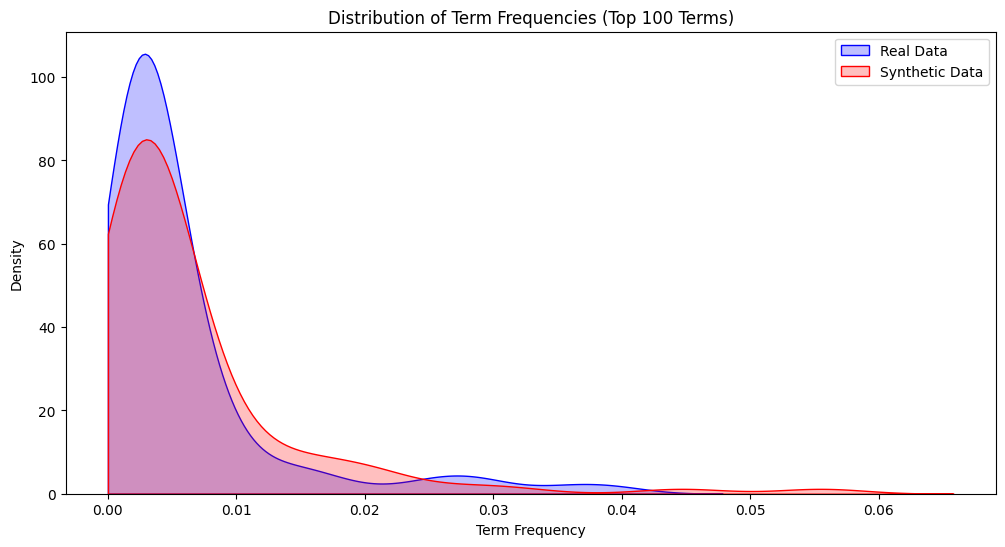

In [129]:
def plot_term_frequency_distribution(df, top_n=100):
    top_terms = df.nlargest(top_n, columns=['tgt', 'syn'])
    
    plt.figure(figsize=(12, 6))
    
    sns.kdeplot(data=top_terms['tgt'], shade=True, color="blue", label="Real Data", clip=(0,None))
    sns.kdeplot(data=top_terms['syn'], shade=True, color="red", label="Synthetic Data", clip=(0,None))
    
    plt.xlabel('Term Frequency')
    plt.ylabel('Density')
    plt.title(f'Distribution of Term Frequencies (Top {top_n} Terms)')
    
    plt.legend()
    plt.show()

plot_term_frequency_distribution(title_term_freq)